In [1]:
import os
import cv2

import multiprocessing
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from itertools import product
from glob import glob
import rasterio as rs
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, 
    BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate,
    RandomContrast
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-07-21 16:48:30.609599: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 16:48:30.632044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 16:48:30.632659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 16:48:31.076683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
import multiprocessing
num_cores = multiprocessing.cpu_count()
config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=num_cores,
                                  intra_op_parallelism_threads=num_cores)
tf.compat.v1.Session(config=config)


In [3]:
IMG_HEIGHT = 64
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 2

def show_map(path,pic1, pic2, pic3):
    img1 = rs.open(path + pic1)
    img2 = rs.open(path + pic2)
    seg = rs.open(path + pic3)

    print(img1.count, img1.height, img1.width, img1.crs)

    band1 = img1.read(1)
    band2 = img2.read(1)
    saida = seg.read(1)

    lista = [band1, band2, saida]
    title = ['Banda 1', 'Banda 2', 'Segmentação']
    plt.figure(figsize=(25, 45))

    for i, name in enumerate(lista):
        shape = lista[i].shape
        plt.subplot(131 + i)
        plt.imshow(lista[i])
        plt.title(str(title[i]) + ' - Formato: ' + str(shape))
    plt.show()

In [4]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

my_unet = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
my_unet.compile(optimizer=Adam(learning_rate=1e-4),  loss='binary_crossentropy', metrics=['accuracy'])
print(my_unet.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 2)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1216      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 64)           0         ['batch_normalization[0][0

In [5]:
# Definir caminhos relativos
path1 = '/home/cristiano/Imagens/imagens_originais/Sentinel-2/banda11/'
path2 = '/home/cristiano/Imagens/imagens_originais/Sentinel-2/banda12/'
path3 = '/home/cristiano/Imagens/imagens_originais/Sentinel-2/mask'

# Obter número de imagens de treino
NUM_TRAIN_IMAGES = len(os.listdir(path3))

# Obter listas de nomes de arquivo
band1_list = np.sort(os.listdir(path1))
band2_list = np.sort(os.listdir(path2))
seg_list = np.sort(os.listdir(path3))

# Criar DataFrame usando contexto do Pandas
with pd.option_context("display.max_columns", None):
    df_train = pd.DataFrame({'banda11': band1_list, 'banda12': band2_list, 'seg': seg_list})

# Obter listas de IDs
train_banda1_id_list = df_train['banda11'].tolist()
train_banda2_id_list = df_train['banda12'].tolist()
train_mask_id_list = df_train['seg'].tolist()

X_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Iterar sobre as listas usando enumerate
for i, (banda11_id, banda12_id, mask_id) in enumerate(zip(train_banda1_id_list, train_banda2_id_list, train_mask_id_list)):
    # Construir caminhos completos
    path_banda11 = os.path.join(path1, banda11_id)
    path_banda12 = os.path.join(path2, banda12_id)
    path_seg = os.path.join(path3, mask_id)

    try:
        # Ler as imagens
        with rs.open(path_banda11) as img11, rs.open(path_banda12) as img12, rs.open(path_seg) as img_seg:
            band11 = img11.read(1)
            band12 = img12.read(1)
            seg = img_seg.read(1)
        
        # Juntar as bandas
        bandas = np.dstack((band11, band12))
        
        # Transformar bandas em valores entre 0 e 255
        bandas = (bandas / 255) * 255
        
        # Inserir a imagem em X_train
        X_train[i] = bandas
        
        # Redimensionar a máscara para a forma (64, 64, 1)
        mask = resize(seg, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
        
        # Normalizar valores da máscara para True/False (ou 0/1)
        mask = mask.astype(bool)
        
        # Inserir a máscara em Y_train
        Y_train[i] = mask
    
    except (rs.RasterioIOError, FileNotFoundError) as e:
        print(f"Erro ao abrir a imagem {banda11_id}: {e}")

print('Shape do X_train:', X_train.shape)
print('Shape do Y_train:', Y_train.shape)

/home/cristiano/projetos/.venv/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape do X_train: (2140, 64, 64, 2)
Shape do Y_train: (2140, 64, 64, 1)


FIT DO TESTE

In [6]:
# Definir caminhos relativos
path1 = '/home/cristiano/Imagens/imagens_originais/Sentinel-2/teste_banda11/'
path2 = '/home/cristiano/Imagens/imagens_originais/Sentinel-2/teste_banda12/'
path3 = '/home/cristiano/Imagens/imagens_originais/Sentinel-2/teste_mask/'

# Obter número de imagens de teste
NUM_TEST_IMAGES = len(os.listdir(path3))

# Obter listas de nomes de arquivo
banda11_list = np.sort(os.listdir(path1))
banda12_list = np.sort(os.listdir(path2))
seg_list = np.sort(os.listdir(path3))

# Criar DataFrame usando contexto do Pandas
with pd.option_context("display.max_columns", None):
    df_test = pd.DataFrame({'banda11': banda11_list, 'banda12': banda12_list, 'seg': seg_list})

# Obter listas de IDs
test_banda11_id_list = df_test['banda11'].tolist()
test_banda12_id_list = df_test['banda12'].tolist()
test_mask_id_list = df_test['seg'].tolist()

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Iterar sobre as listas usando enumerate
for i, (banda11_id, banda12_id, mask_id) in enumerate(zip(test_banda11_id_list, test_banda12_id_list, test_mask_id_list)):
    # Construir caminhos completos
    path_banda11 = os.path.join(path1, banda11_id)
    path_banda12 = os.path.join(path2, banda12_id)
    path_seg = os.path.join(path3, mask_id)

    try:
        # Ler as imagens
        with rs.open(path_banda11) as img11, rs.open(path_banda12) as img12, rs.open(path_seg) as img3:
            band11 = img11.read(1)
            band12 = img12.read(1)
            seg = img3.read(1)
        
        # Juntar as bandas
        bandas = np.dstack((band11, band12))
        
        # Transformar bandas em valores entre 0 e 255
        bandas = (bandas / 255) * 255
        
        # Inserir a imagem em X_test
        X_test[i] = bandas
        
        # Redimensionar a máscara para a forma (64, 64, 1)
        mask = resize(seg, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
        
        # Normalizar valores da máscara para True/False (ou 0/1)
        mask = mask.astype(bool)
        
        # Inserir a máscara em Y_test
        Y_test[i] = mask
    
    except (rs.RasterioIOError, FileNotFoundError) as e:
        print(f"Erro ao abrir a imagem {banda11_id}: {e}")

print('Shape do X_test:', X_test.shape)
print('Shape do Y_test:', Y_test.shape)

Shape do X_test: (1270, 64, 64, 2)
Shape do Y_test: (1270, 64, 64, 1)


In [7]:
filepath = "/home/cristiano/projetos/modelos/model60-40.h5"
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystopper, checkpoint]
history = my_unet.fit(X_train, Y_train, validation_split=0.2, batch_size=64, epochs=10, callbacks=callbacks_list)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.9734
Epoch 1: val_loss improved from inf to 2.25597, saving model to /home/cristiano/projetos/modelos/model60-40.h5


/home/cristiano/projetos/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 128s 5s/step - loss: 0.2905 - accuracy: 0.9734 - val_loss: 2.2560 - val_accuracy: 0.0274
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9961
Epoch 2: val_loss improved from 2.25597 to 1.31361, saving model to /home/cristiano/projetos/modelos/model60-40.h5
27/27 [==============================] - 126s 5s/step - loss: 0.1409 - accuracy: 0.9961 - val_loss: 1.3136 - val_accuracy: 0.1097
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9980
Epoch 3: val_loss improved from 1.31361 to 0.67752, saving model to /home/cristiano/projetos/modelos/model60-40.h5
27/27 [==============================] - 126s 5s/step - loss: 0.1031 - accuracy: 0.9980 - val_loss: 0.6775 - val_accuracy: 0.6895
Epoch 4/10
27/27 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9982
Epoch 4: val_loss improved from 0.67752 to 0.35997, saving model to /home/cristiano/projetos/model

In [8]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

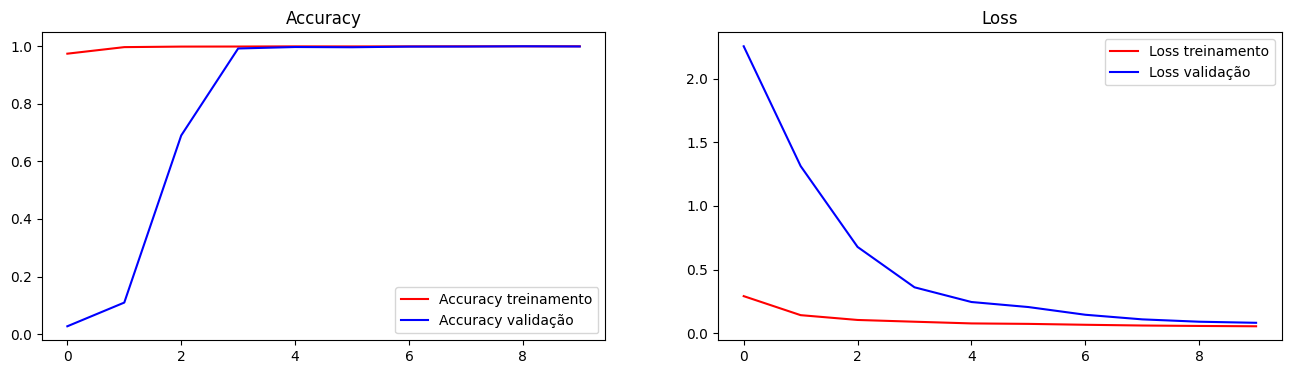

In [9]:
def mostrar_graficos(history):
  fig = plt.gcf()
  fig.set_size_inches(16,4)
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], 'red', label='Accuracy treinamento')
  plt.plot(history.history['val_accuracy'], 'blue', label='Accuracy validação')
  plt.legend()
  plt.title('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], 'red', label='Loss treinamento')
  plt.plot(history.history['val_loss'], 'blue', label='Loss validação')
  plt.legend()
  plt.title('Loss')
  plt.show()

mostrar_graficos(history)

In [10]:
# use the best epoch
my_unet.load_weights('/home/cristiano/projetos/modelos/model60-40.h5')
test_preds = my_unet.predict(X_test)

# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)
preds_test_thresh = preds_test_thresh.reshape((len(X_test), IMG_WIDTH, IMG_HEIGHT, 1))

print("Evaluate on test data")
results = my_unet.evaluate(X_test, Y_test)
print("test loss: ", results)

"""IOU"""

mean_iou1 = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou1.update_state(Y_test, preds_test_thresh, sample_weight=None)
iou = mean_iou1.result().numpy()
print("IOU: ", iou)

"""Accuracy"""

acc1 = tf.keras.metrics.Accuracy()
acc1.update_state(Y_test, preds_test_thresh)
acc = acc1.result().numpy()
print("acurácia: ", acc)

40/40 [==============================] - 17s 424ms/step
Evaluate on test data
40/40 [==============================] - 17s 422ms/step - loss: 0.0773 - accuracy: 0.9981
test loss:  [0.07725448906421661, 0.9981301426887512]
IOU:  0.86319697
acurácia:  0.99813014


In [ ]:

diretorio_destino = '/home/emanoelcepr@ccasj.intraer/projetos/u-net/PREDS'

# Verifica se o diretório de destino existe, caso contrário, cria-o
if not os.path.exists(diretorio_destino):
    os.makedirs(diretorio_destino)

# Percorre a lista de imagens e salva cada uma no diretório destino
for i, imagem in enumerate(df_test):
    nome_arquivo = f'imagem_{i}.tif'  # Nome do arquivo de destino
    caminho_arquivo = os.path.join(diretorio_destino, nome_arquivo)  # Caminho completo do arquivo
    imagem = Image.fromarray(imagem)  # Converte a imagem para o formato PIL
    imagem.save(caminho_arquivo)  # Salva a imagem no diretório destino

print('Imagens salvas com sucesso!')

In [ ]:
def encontrar_indices_com_valor_um(matrizes):
    indices = []
    for indice, matriz in enumerate(matrizes):
        if np.any(matriz == 1):
            indices.append(indice)
    return indices

def salvar_indices_em_arquivo(indices, diretorio_destino):
    nome_arquivo = 'indices.txt'
    caminho_arquivo = os.path.join(diretorio_destino, nome_arquivo)
    with open(caminho_arquivo, 'w') as arquivo:
        for indice in indices:
            arquivo.write(str(indice) + '\n')

diretorio_destino = '/home/emanoelcepr@ccasj.intraer/projetos/u-net/INDICES-60-40'

# Verifica se o diretório de destino existe, caso contrário, cria-o
if not os.path.exists(diretorio_destino):
    os.makedirs(diretorio_destino)

# Encontra os índices das matrizes com valor 1
indices_matrizes_com_valor_um = encontrar_indices_com_valor_um(preds_test_thresh)

# Salva os índices em um arquivo de texto no diretório destino
salvar_indices_em_arquivo(indices_matrizes_com_valor_um, diretorio_destino)

print('Índices salvos com sucesso no arquivo indices.txt.')




In [ ]:
import os
from PIL import Image

diretorio_destino = 'caminho/do/diretorio/destino/'

# Verifica se o diretório de destino existe, caso contrário, cria-o
if not os.path.exists(diretorio_destino):
    os.makedirs(diretorio_destino)

# Percorre a lista de imagens e salva cada uma no diretório destino
for i, imagem in enumerate(df_test):
    nome_arquivo = f'imagem_{i}.png'  # Nome do arquivo de destino
    caminho_arquivo = os.path.join(diretorio_destino, nome_arquivo)  # Caminho completo do arquivo
    imagem = Image.fromarray(imagem)  # Converte a imagem para o formato PIL
    imagem.save(caminho_arquivo)  # Salva a imagem no diretório destino

print('Imagens salvas com sucesso!')


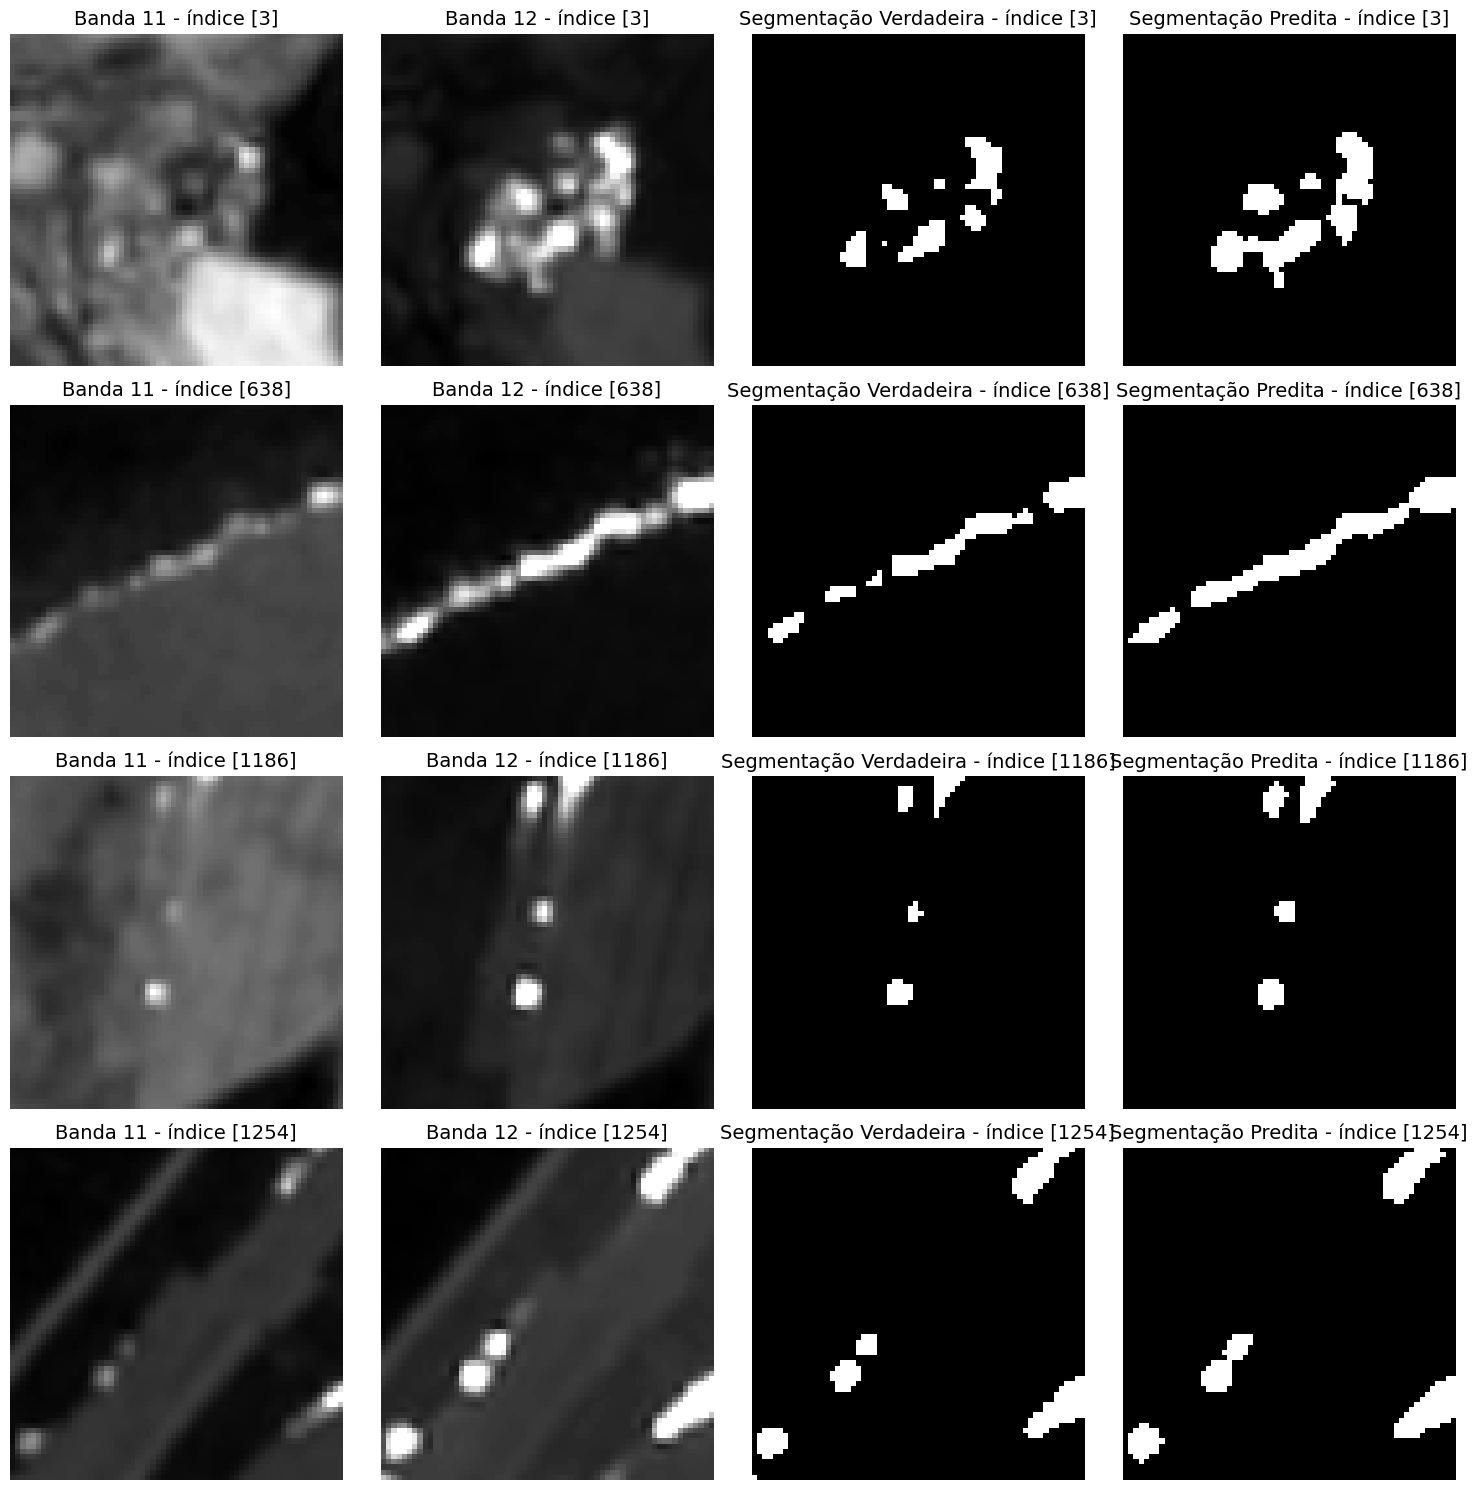

In [26]:
def plot_resultado(quantidade=4, random=14):
    # indices = df_test.sample(quantidade, random_state=random).index.values
    indices = [3, 638, 1186, 1254]
    plt.figure(figsize=(15, 15))
    j = 1
    for i in range(quantidade):
        # rgb = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b1 = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b2 = X_test[indices[i], :, :, 1].reshape((IMG_HEIGHT, IMG_WIDTH))
        seg = Y_test.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[indices[i]]
        img_pred = preds_test_thresh[indices[i]].reshape((IMG_HEIGHT, IMG_WIDTH))

        imgs = [b1, b2, seg, img_pred]
        names = ['Banda 11', 'Banda 12', 'Segmentação Verdadeira', 'Segmentação Predita']

        for img, nome in zip(imgs, names):
            plt.subplot(quantidade, 4, j)
            plt.imshow(img, cmap='gray')
            plt.title(str(nome) + ' - índice [' + str(indices[i]) + ']', fontsize=14)
            plt.axis('off')
            j += 1
    plt.tight_layout()
    plt.show()


plot_resultado()

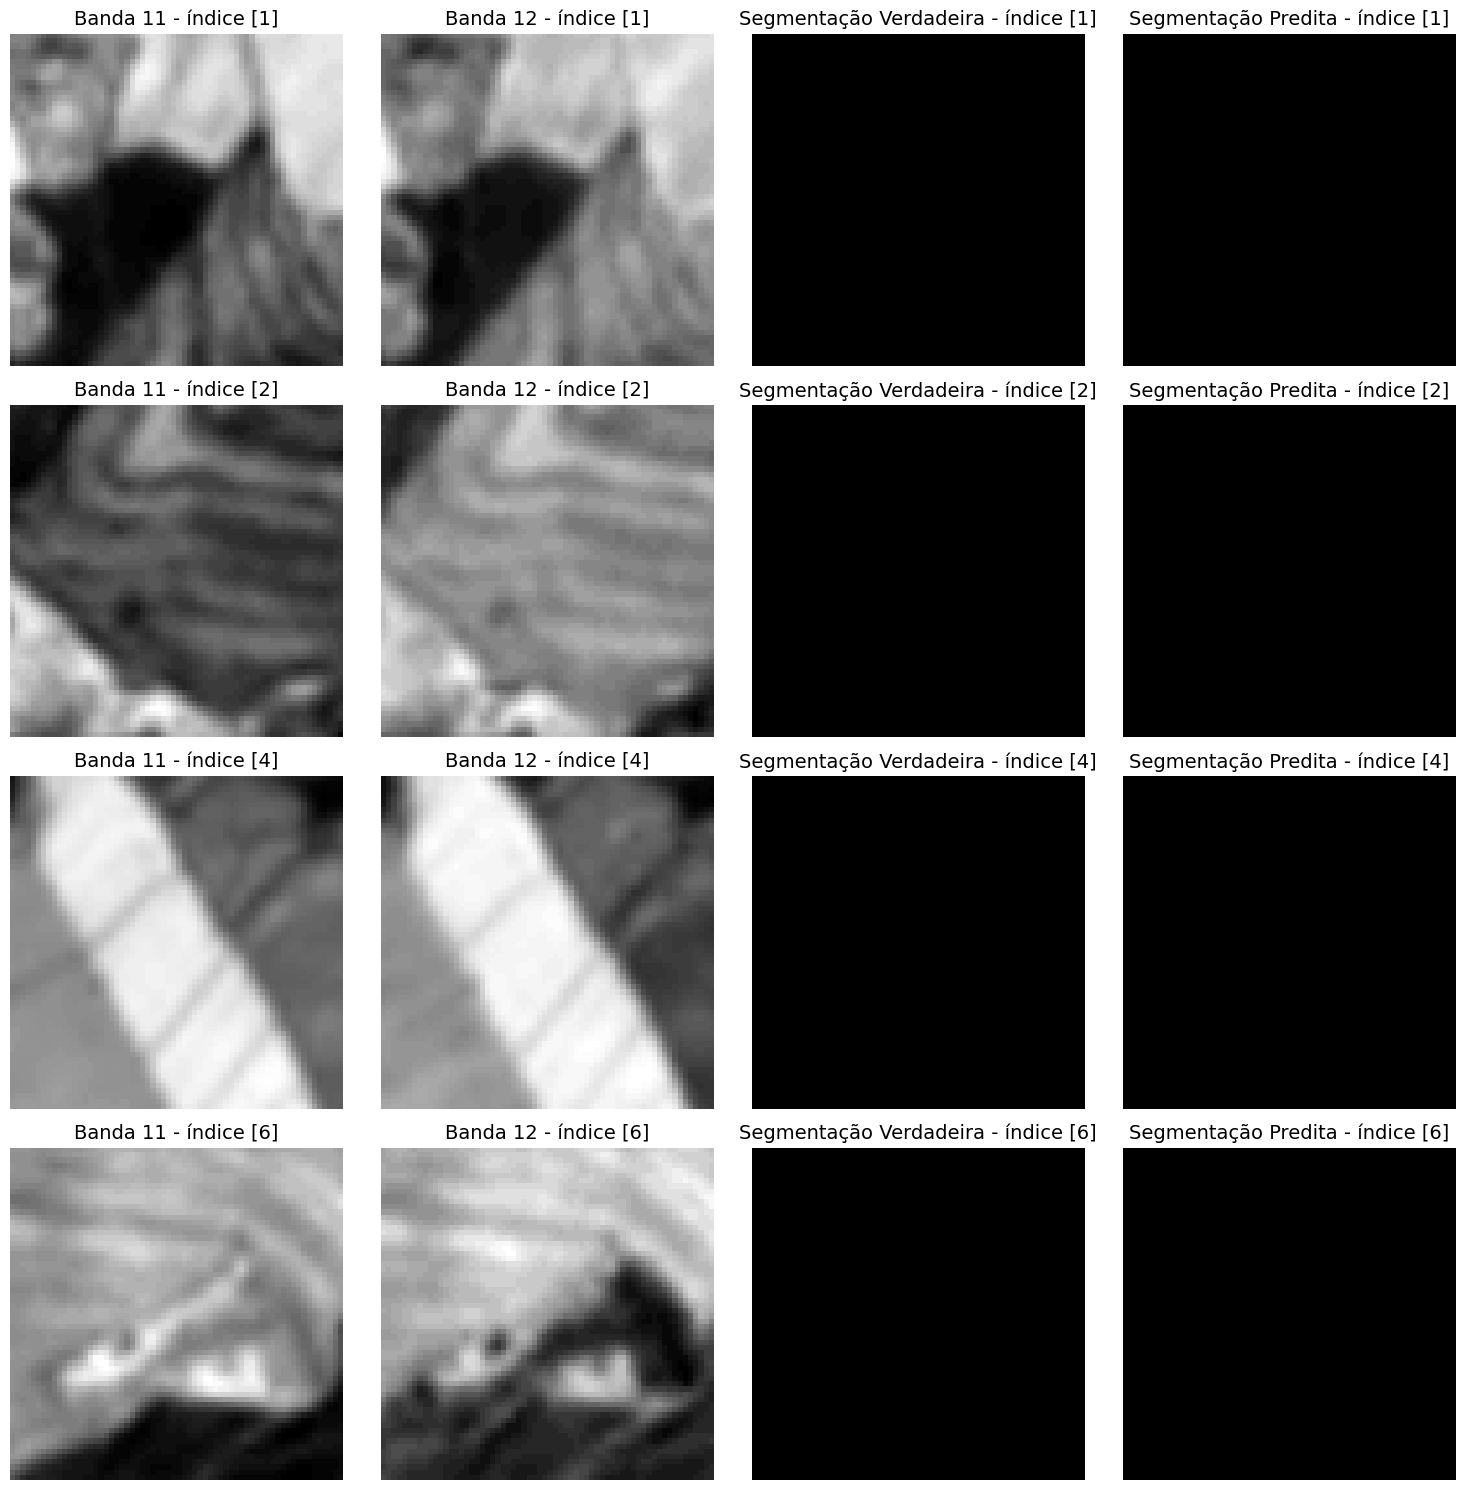

In [28]:
def plot_resultado(quantidade=4, random=14):
    # indices = df_test.sample(quantidade, random_state=random).index.values
    indices = [1, 2, 4, 6]
    plt.figure(figsize=(15, 15))
    j = 1
    for i in range(quantidade):
        # rgb = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b1 = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b2 = X_test[indices[i], :, :, 1].reshape((IMG_HEIGHT, IMG_WIDTH))
        seg = Y_test.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[indices[i]]
        img_pred = preds_test_thresh[indices[i]].reshape((IMG_HEIGHT, IMG_WIDTH))

        imgs = [b1, b2, seg, img_pred]
        names = ['Banda 11', 'Banda 12', 'Segmentação Verdadeira', 'Segmentação Predita']

        for img, nome in zip(imgs, names):
            plt.subplot(quantidade, 4, j)
            plt.imshow(img, cmap='gray')
            plt.title(str(nome) + ' - índice [' + str(indices[i]) + ']', fontsize=14)
            plt.axis('off')
            j += 1
    plt.tight_layout()
    plt.show()


plot_resultado()